In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [2]:
data = pd.read_csv('../ssd_data/final_data/final_MB1.csv')
# 'index' 컬럼을 datetime 형태로 변환
data['index'] = pd.to_datetime(data['index'])

data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,6653.0,100.0,0.0,97.0,12707.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,4.976439e+10,99.0,3.939800e+10,0.0
1,2019-01-02,6653.0,100.0,0.0,97.0,12731.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.034821e+10,99.0,3.956458e+10,0.0
2,2019-01-03,6653.0,100.0,0.0,97.0,12755.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.082254e+10,99.0,3.973763e+10,0.0
3,2019-01-04,6653.0,100.0,0.0,97.0,12779.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.121309e+10,99.0,3.990997e+10,0.0
4,2019-01-05,6653.0,100.0,0.0,97.0,12803.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.157860e+10,99.0,4.008257e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71551,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,1.0
71552,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,1.0
71553,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,1.0
71554,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,1.0


In [5]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

label_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)
label_1
# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(242, 1)

In [6]:
disk_list = list(data['disk_id'].drop_duplicates())
failure_disk_list = list(label_1.values.squeeze())
healthy_disk_list = list(set(disk_list) - set(failure_disk_list))

In [7]:
import random
random.seed(42)

# 194개씩 랜덤하게 선택
healthy_disk_194 = random.sample(healthy_disk_list, 194)
failure_disk_194 = random.sample(failure_disk_list, 194)

print(len(healthy_disk_194))
print(len(failure_disk_194))

# 194개에서 155/39 개로 validation set 구축
healthy_disk_155 = random.sample(healthy_disk_194,155) #train set
healthy_disk_39 = list(set(healthy_disk_194) - set(healthy_disk_155)) #validation set

failure_disk_155 = random.sample(failure_disk_194, 155) #train set
failure_disk_39 = list(set(failure_disk_194) - set(failure_disk_155)) #validation set

print('train_healthy_count:', len(healthy_disk_155))
print('train_failure_count:', len(failure_disk_155))

print('val_healthy_count:', len(healthy_disk_39))
print('val_failure_count:',len(failure_disk_39))
# 48개씩 랜덤하게 선택
healthy_disk_48 = random.sample(list(set(healthy_disk_list) - set(healthy_disk_194)), 48)
failure_disk_48 = list(set(failure_disk_list) - set(failure_disk_194))

print('test_healthy_count:',len(healthy_disk_48))
print('test_healthy_count:',len(failure_disk_48))

194
194
train_healthy_count: 155
train_failure_count: 155
val_healthy_count: 39
val_failure_count: 39
test_healthy_count: 48
test_healthy_count: 48


In [8]:
H_disk_194 = data[data['disk_id'].isin(healthy_disk_194)]
F_disk_194 = data[data['disk_id'].isin(failure_disk_194)]

H_disk_155 = data[data['disk_id'].isin(healthy_disk_155)]
F_disk_155 = data[data['disk_id'].isin(failure_disk_155)]

H_disk_39 = data[data['disk_id'].isin(healthy_disk_39)]
F_disk_39 = data[data['disk_id'].isin(failure_disk_39)]

H_disk_48 = data[data['disk_id'].isin(healthy_disk_48)]
F_disk_48 = data[data['disk_id'].isin(failure_disk_48)]

# train set, validation set, test set 생성
final_train_set = pd.concat([H_disk_194,F_disk_194],ignore_index=True,axis=0) #validation set으로 최적의 epoch 찾은 후, 해당 epoch으로 다시 training 시킬 예정
train_set = pd.concat([H_disk_155,F_disk_155],ignore_index=True,axis=0)
val_set = pd.concat([H_disk_39,F_disk_39],ignore_index=True,axis=0)
test_set = pd.concat([H_disk_48,F_disk_48],ignore_index=True,axis=0)

In [9]:
# feature와 label 구분
final_X_train = final_train_set.drop(columns=['disk_id','index','label'])
X_train = train_set.drop(columns=['disk_id','index','label'])
X_val = val_set.drop(columns=['disk_id','index','label'])
X_test = test_set.drop(columns=['disk_id','index','label'])

final_y_train = final_train_set['label']
y_train = train_set['label']
y_val = val_set['label']
y_test = test_set['label']

In [14]:
# Random Forest 모델 생성
rf = RandomForestClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 150)

In [16]:
rf.fit(final_X_train,final_y_train)

RandomForestClassifier(max_depth=20, n_estimators=150)

In [ ]:
# Test 세트를 사용하여 최종 모델의 성능 평가
y_pred = rf.predict(X_test)

In [ ]:
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("F1-score on Test Set:", f1_score(y_test, y_pred))
print("Precision on Test Set:", precision_score(y_test, y_pred))
print("Recall on Test Set:", recall_score(y_test, y_pred))

Accuracy on Test Set: 0.9269018274543136
F1-score on Test Set: 0.6090909090909091
Precision on Test Set: 0.67
Recall on Test Set: 0.5583333333333333


In [17]:
# Test 세트를 사용하여 최종 모델의 성능 평가
y_pred = rf.predict(X_test)

print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("F1-score on Test Set:", f1_score(y_test, y_pred))
print("Precision on Test Set:", precision_score(y_test, y_pred))
print("Recall on Test Set:", recall_score(y_test, y_pred))

Accuracy on Test Set: 0.9295934268309959
F1-score on Test Set: 0.6291044776119404
Precision on Test Set: 0.6798387096774193
Recall on Test Set: 0.5854166666666667


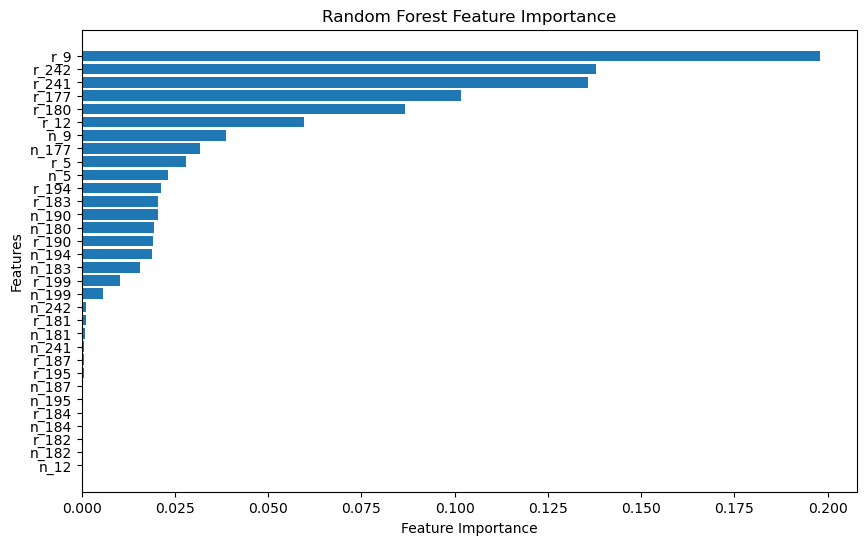

In [21]:
# Feature Importance 시각화
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

In [18]:
rf.predict(X_test)

array([0., 0., 0., ..., 1., 1., 1.])

In [3]:
# 데이터셋 준비 (X: 특성, y: 타겟)
X = data.drop(['disk_id', 'index', 'label'], axis=1)
y = data['label']

In [4]:
# 데이터를 train/test 세트로 나누기 (비율: 80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Random Forest 모델 생성
rf = RandomForestClassifier()

In [6]:
# Grid Search를 위한 매개변수 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [7]:
# Grid Search 객체 생성
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=['accuracy', 'f1', 'precision', 'recall'], refit='accuracy')

In [8]:
# Grid Search 수행
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             refit='accuracy',
             scoring=['accuracy', 'f1', 'precision', 'recall'])

In [9]:
# Grid Search 결과 출력
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_accuracy'], results['params']):
    print("Accuracy: {:.4f} with: {}".format(mean_score, params))

Accuracy: 0.9945 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9949 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9950 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.9944 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.9946 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.9946 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Accuracy: 0.9936 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.9936 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.9940 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
A

In [10]:
# 최적의 하이퍼파라미터로 훈련된 최종 모델을 가져옴
best_model = grid_search.best_estimator_

In [11]:
# Test 세트를 사용하여 최종 모델의 성능 평가
y_pred = best_model.predict(X_test)

In [12]:
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("F1-score on Test Set:", f1_score(y_test, y_pred))
print("Precision on Test Set:", precision_score(y_test, y_pred))
print("Recall on Test Set:", recall_score(y_test, y_pred))

Accuracy on Test Set: 0.9960871995528228
F1-score on Test Set: 0.9802259887005649
Precision on Test Set: 0.9879003558718861
Recall on Test Set: 0.9726699369306236


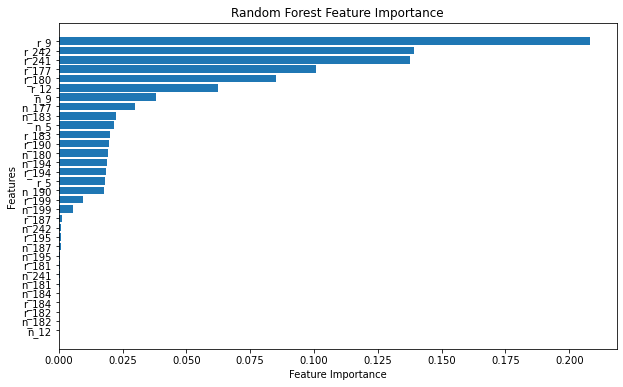

In [13]:
# Feature Importance 시각화
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(X.shape[1]), feature_importance[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

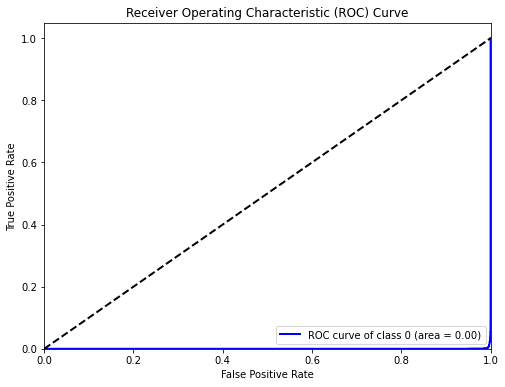

In [18]:
# AUC Curve 시각화
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], best_model.predict_proba(X_test)[:, i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])  # You can add more colors for more classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled,y_train)

RandomForestClassifier(random_state=42)

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

y_pred = clf.predict(X_test_scaled)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"Macro_f1_score : {f1_score(y_test, y_pred,average='macro')}")
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")

Accuracy : 0.9124401581905225
Macro_f1_score : 0.7354453078893624
Precision : 0.575168918918919
Recall : 0.47291666666666665


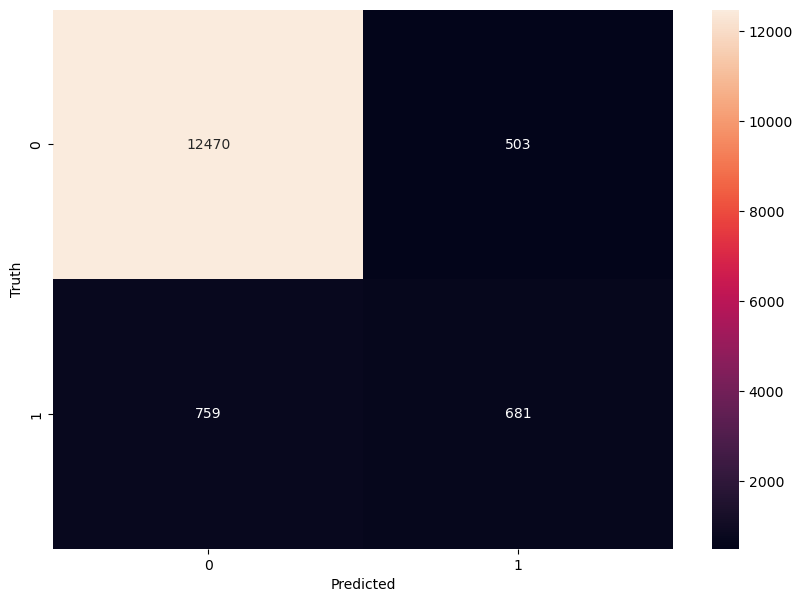

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [24]:
import numpy as np

print(y_test.shape)

count_ones = np.count_nonzero(y_test == 1)

print("Number of ones in y_test_window:", count_ones)

(14413,)
Number of ones in y_test_window: 1440


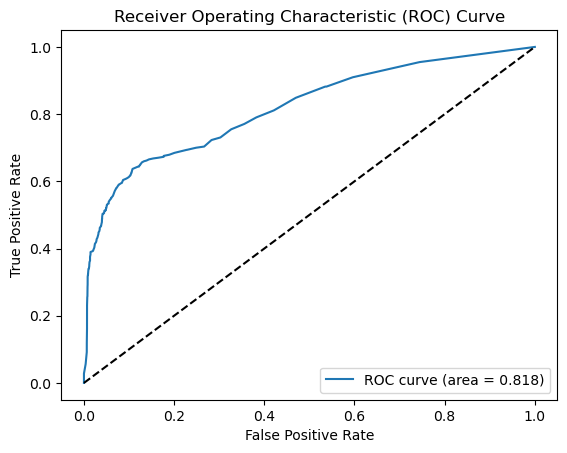

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = clf.predict_proba(X_test_scaled)[:, 1]

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred_prob = clf.predict_proba(X_test_scaled)[:, 1] # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred_prob >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test, y_pred_class, target_names=['healthy', 'failure']))

Best Threshold=0.270000, Sensitivity=0.637, Specificity=0.892, J=0.529
              precision    recall  f1-score   support

     healthy       0.96      0.89      0.92     12973
     failure       0.40      0.64      0.49      1440

    accuracy                           0.87     14413
   macro avg       0.68      0.76      0.71     14413
weighted avg       0.90      0.87      0.88     14413



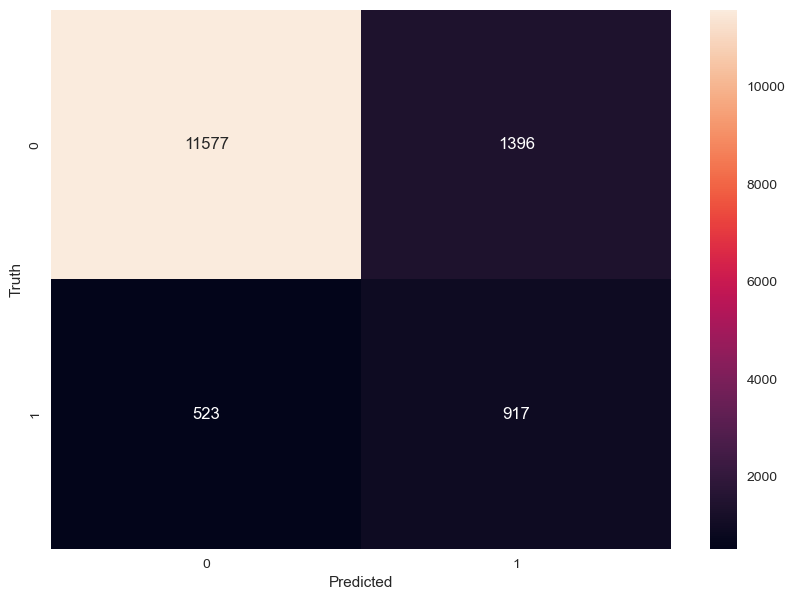

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

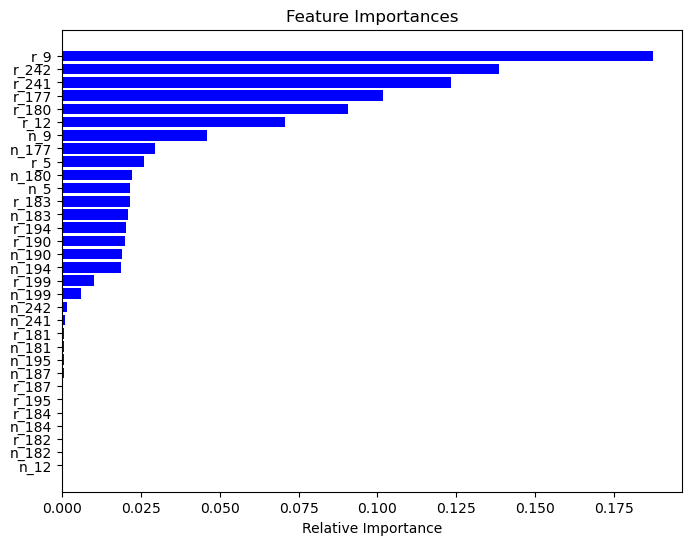

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# 특성 중요도
feature_importances = clf.feature_importances_

# 특성 중요도를 내림차순으로 정렬
indices = np.argsort(feature_importances)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## pycaret

In [32]:
pycaret_dataset = train_set.drop(columns=['disk_id','index'])
pycaret_test_dataset = test_set.drop(columns=['disk_id','index'])

In [31]:
import pandas as pd
from pycaret.classification import *

# PyCaret 설정 초기화
# train_data: 사용할 훈련 데이터프레임
# target: 예측하고자 하는 컬럼 이름 (이진 분류의 목표 변수)
s = setup(data=pycaret_dataset, target='label',fold=5, session_id=123,normalize=True, normalize_method='minmax')

# 모델 비교
# 모든 사용 가능한 모델을 훈련시키고 성능을 비교합니다.
best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Binary
3,Original data shape,"(57143, 33)"
4,Transformed data shape,"(57143, 33)"
5,Transformed train set shape,"(40000, 33)"
6,Transformed test set shape,"(17143, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9945,0.9996,0.9605,0.9852,0.9726,0.9696,0.9697,0.9680
et,Extra Trees Classifier,0.9930,0.9996,0.9595,0.9710,0.9652,0.9613,0.9613,0.6620
dt,Decision Tree Classifier,0.9922,0.9765,0.9568,0.9663,0.9615,0.9572,0.9572,0.1720
lightgbm,Light Gradient Boosting Machine,0.9880,0.9985,0.9050,0.9754,0.9389,0.9322,0.9330,0.4620
knn,K Neighbors Classifier,0.9822,0.9883,0.8976,0.9249,0.9111,0.9011,0.9013,1.3060
gbc,Gradient Boosting Classifier,0.9473,0.9447,0.5140,0.9423,0.6651,0.6392,0.6740,1.9960
ada,Ada Boost Classifier,0.9224,0.8818,0.2833,0.8619,0.4260,0.3956,0.4674,0.5920
lr,Logistic Regression,0.9002,0.7856,0.0341,0.7000,0.0650,0.0561,0.1393,1.8480
ridge,Ridge Classifier,0.9002,0.0000,0.0204,0.9833,0.0399,0.0359,0.1335,0.1020
svm,SVM - Linear Kernel,0.9000,0.0000,0.0179,0.9818,0.0352,0.0316,0.1245,0.1400


In [44]:
# 특정 모델 선택 및 훈련
# 예: 로지스틱 회귀 모델
model = create_model('rf')

# 모델 성능 평가 (테스트 데이터로)
predict_model(model, data=pycaret_test_dataset)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9938,0.9996,0.9472,0.9910,0.9686,0.9651,0.9654
1,0.9949,0.9996,0.9620,0.9874,0.9745,0.9717,0.9718
2,0.9942,0.9995,0.9571,0.9861,0.9714,0.9682,0.9683
3,0.9954,0.9998,0.9693,0.9850,0.9771,0.9745,0.9746
4,0.9942,0.9997,0.9669,0.9765,0.9716,0.9684,0.9685
Mean,0.9945,0.9996,0.9605,0.9852,0.9726,0.9696,0.9697
Std,0.0006,0.0001,0.0079,0.0048,0.0029,0.0032,0.0032


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9177,0.8216,0.4625,0.6178,0.5290,0.4849,0.4910


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [29]:
tuned_model = tune_model(model)
tuned_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9430,0.8649,0.5149,0.7828,0.6212,0.5918,0.6070
1,0.9421,0.8598,0.4940,0.7905,0.6081,0.5786,0.5973
2,0.9432,0.8810,0.4940,0.8058,0.6125,0.5838,0.6042
3,0.9478,0.8863,0.5446,0.8206,0.6547,0.6278,0.6432
4,0.9427,0.8792,0.4821,0.8100,0.6045,0.5757,0.5983
5,0.9419,0.8758,0.4702,0.8103,0.5951,0.5662,0.5906
6,0.9405,0.8743,0.4925,0.7674,0.6000,0.5695,0.5859
7,0.9421,0.8673,0.4851,0.7990,0.6037,0.5745,0.5954
8,0.9462,0.8734,0.5298,0.8128,0.6414,0.6137,0.6302


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [30]:
# 모델 성능 평가 (테스트 데이터로)
predict_model(tuned_model, data=test_data,)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9737,0.8814,0.5204,0.4562,0.4862,0.4727,0.4738


,disk_id,ds,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,...,n_196,r_196,r_197,r_198,r_199,n_175,r_175,label,prediction_label,prediction_score
18176,5288,2019-05-05,4.294967e+09,98.0,0.0,43254.0,46.0,100.0,0.0,100.0,...,100.0,0.0,0.0,0.0,0.0,100.0,1.086862e+12,0,0,1.00
61170,15511,2019-05-05,4.294967e+09,95.0,0.0,47601.0,39.0,100.0,0.0,100.0,...,100.0,0.0,0.0,0.0,0.0,100.0,1.202794e+12,0,0,1.00
60014,23071,2019-05-05,4.294967e+09,54.0,2031.0,49507.0,32.0,100.0,0.0,100.0,...,65.0,2031.0,2.0,0.0,0.0,100.0,1.254648e+12,0,0,0.99
43872,24148,2019-05-05,4.294967e+09,94.0,0.0,49465.0,38.0,100.0,0.0,100.0,...,100.0,0.0,0.0,0.0,0.0,100.0,1.254687e+12,0,0,0.93
7252,11936,2019-05-05,4.294967e+09,97.0,0.0,43380.0,36.0,100.0,0.0,100.0,...,100.0,0.0,0.0,0.0,0.0,100.0,1.095480e+12,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64690,42173,2019-06-30,4.294967e+09,97.0,0.0,50421.0,47.0,100.0,0.0,100.0,...,100.0,0.0,0.0,0.0,0.0,100.0,1.267203e+12,0,0,0.98
68444,5888,2019-06-30,4.294967e+09,98.0,0.0,44234.0,79.0,100.0,0.0,100.0,...,100.0,0.0,0.0,0.0,0.0,100.0,1.104198e+12,0,0,0.98
7987,32191,2019-06-30,4.294967e+09,98.0,0.0,41561.0,34.0,100.0,0.0,100.0,...,100.0,0.0,0.0,0.0,0.0,100.0,1.048310e+12,0,0,0.99
37982,25604,2019-06-30,4.294967e+09,97.0,0.0,48855.0,32.0,100.0,0.0,100.0,...,100.0,0.0,0.0,0.0,0.0,100.0,1.233221e+12,0,0,0.97


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from datetime import date, timedelta
from pycaret import time_series as ts
from pycaret.time_series import TSForecastingExperiment
import refinitiv.data as rd
from os.path import exists


exp = TSForecastingExperiment()

exp.setup(data=train_data, target='label', fh=60, fold=5, session_id=123)



In [ ]:
exp.models()

## 5 window(미완성..)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 데이터 프레임 예시 (shuffled_df 라는 데이터 프레임이 있다고 가정)
# shuffled_df = pd.DataFrame(...)

# model과 disk_id별로 unique한 그룹을 찾습니다.
grouped = shuffled_df.groupby(['model', 'disk_id'])

# lag window size
window_size = 5

# 결과를 저장할 빈 데이터프레임을 만듭니다.
result = pd.DataFrame()

# tqdm을 사용하여 진행 상태를 표시합니다.
for name, group in tqdm(grouped, desc="Processing groups"):
    # 변수들에 대한 lag feature를 생성합니다. (4번째부터 마지막에서 두 번째 열까지)
    features = group.iloc[:, 3:-1].values
    labels = group.iloc[:, -1].values
    dates = group.iloc[:, 1].values
    lag_features = []
    lag_labels = []
    lag_dates = []
    
    # window를 이동시키며 lag feature를 만듭니다.
    for i in range(len(features) - window_size + 1):
        window = features[i:i + window_size].flatten()
        lag_features.append(window)
        lag_labels.append(labels[i + window_size - 1])
        lag_dates.append(dates[i + window_size - 1])
    
    # 데이터프레임 형태로 변환합니다.
    num_features = len(group.columns) - 4
    columns = [f'var_{j}_lag_{i}' for j in range(1, num_features+1) for i in range(1, window_size+1)]
    lag_df = pd.DataFrame(lag_features, columns=columns)
    
    # 기존 정보를 포함시킵니다.
    lag_df['model'] = name[0]
    lag_df['disk_id'] = name[1]
    lag_df['date'] = lag_dates  # 날짜를 추가합니다.
    
    # Label을 추가합니다.
    lag_df['label'] = lag_labels
    
    # 결과 데이터프레임에 추가합니다.
    result = pd.concat([result, lag_df])

# 결과를 출력합니다.
print(result)

In [81]:
grouped = data.groupby(['disk_id'])

window_5_df = pd.DataFrame()

window_size = 5
for name,disk in tqdm(grouped):
    
    window_5_df['disk_id'] = disk['disk_id']
    window_5_df['ds']= disk['ds']
    window_5_df['label'] = disk['label']

    for i in range(window_size-1,-1,-1):
        for column in features.columns:
            window_5_df[f'{column}_t_{i}'] = features[column].shift(-i)
        


window_5_df

  0%|          | 0/548 [00:00<?, ?it/s]

100%|██████████| 548/548 [00:22<00:00, 24.35it/s]


,disk_id,ds,label,r_1_t_4,n_5_t_4,r_5_t_4,r_9_t_4,r_12_t_4,n_171_t_4,r_171_t_4,...,r_190_t_0,r_194_t_0,r_195_t_0,n_196_t_0,r_196_t_0,r_197_t_0,r_198_t_0,r_199_t_0,n_175_t_0,r_175_t_0
21031,NaN,NaT,NaN,4.294967e+09,93.0,2.0,46475.0,146.0,100.0,1.0,...,0.0,16.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,9.627019e+11
21032,NaN,NaT,NaN,4.294967e+09,96.0,0.0,40980.0,29.0,100.0,0.0,...,0.0,16.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,9.664302e+11
21033,NaN,NaT,NaN,4.294967e+09,97.0,0.0,42683.0,34.0,100.0,0.0,...,0.0,16.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,9.665241e+11
21034,NaN,NaT,NaN,4.294967e+09,97.0,0.0,40492.0,36.0,100.0,0.0,...,0.0,16.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,9.666179e+11
21035,NaN,NaT,NaN,4.294967e+09,93.0,0.0,46454.0,34.0,100.0,0.0,...,0.0,16.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,9.667118e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21206,NaN,NaT,NaN,4.294967e+09,57.0,2037.0,45807.0,34.0,100.0,0.0,...,0.0,16.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,1.070086e+12
21207,NaN,NaT,NaN,4.294967e+09,93.0,6.0,50944.0,47.0,100.0,12.0,...,0.0,16.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,1.073815e+12
21208,NaN,NaT,NaN,1.750761e+08,98.0,3.0,39806.0,50.0,100.0,4.0,...,0.0,16.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,1.073909e+12
21209,NaN,NaT,NaN,4.294967e+09,97.0,0.0,42603.0,0.0,0.0,0.0,...,0.0,16.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,1.074002e+12


In [64]:
for i in range(0,window_size,-1):
    for column in features.columns:
        window_5_df[f'{column}_t_{i}'] = features[column].shift(-i)
window_5_df

,disk_id,ds,label
21031,NaN,NaT,NaN
21032,NaN,NaT,NaN
21033,NaN,NaT,NaN
21034,NaN,NaT,NaN
21035,NaN,NaT,NaN
...,...,...,...
21206,NaN,NaT,NaN
21207,NaN,NaT,NaN
21208,NaN,NaT,NaN
21209,NaN,NaT,NaN


In [77]:
window_5_df = pd.DataFrame()
for i in range(window_size-1,-1,-1):
    for column in features.columns:
        window_5_df[f'{column}_t_{i}'] = features[column].shift(-i)
window_5_df

,r_1_t_4,n_5_t_4,r_5_t_4,r_9_t_4,r_12_t_4,n_171_t_4,r_171_t_4,n_172_t_4,r_172_t_4,n_173_t_4,...,r_190_t_0,r_194_t_0,r_195_t_0,n_196_t_0,r_196_t_0,r_197_t_0,r_198_t_0,r_199_t_0,n_175_t_0,r_175_t_0
0,4.294967e+09,96.0,0.0,43946.0,39.0,100.0,0.0,100.0,0.0,8.0,...,12.0,12.0,7.571336e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.030799e+12
27882,4.294967e+09,98.0,0.0,40646.0,36.0,100.0,0.0,100.0,0.0,76.0,...,0.0,11.0,0.000000e+00,100.0,0.0,0.0,0.0,0.0,100.0,9.711676e+11
50690,4.294967e+09,94.0,0.0,46787.0,26.0,100.0,0.0,100.0,0.0,30.0,...,21.0,21.0,7.766713e+08,65.0,2044.0,2.0,0.0,0.0,100.0,1.027106e+12
64029,4.294967e+09,98.0,0.0,36378.0,60.0,100.0,0.0,100.0,0.0,56.0,...,17.0,17.0,2.268835e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.189751e+12
2679,4.294967e+09,96.0,0.0,38057.0,0.0,0.0,0.0,0.0,0.0,1.0,...,19.0,19.0,1.231659e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.099740e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66317,4.294967e+09,96.0,0.0,13320.0,0.0,0.0,0.0,0.0,0.0,46.0,...,15.0,15.0,7.830364e+08,100.0,0.0,0.0,0.0,0.0,1.0,1.069647e+12
2857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,1.263533e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.207103e+12
57586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.0,17.0,1.832518e+09,99.0,1.0,0.0,0.0,0.0,100.0,1.297252e+12
57758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,12.0,1.105051e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.048451e+12


In [5]:
data

,disk_id,ds,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,label
0,12421,2019-01-01,4.294967e+09,98.0,0.0,40821.0,38.0,100.0,0.0,100.0,...,12.0,7.571336e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.030799e+12,0
47319,28267,2019-01-01,4.294967e+09,95.0,0.0,46339.0,41.0,100.0,0.0,100.0,...,14.0,2.202509e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.159917e+12,0
19172,28724,2019-01-01,4.294967e+09,97.0,0.0,38319.0,0.0,0.0,0.0,0.0,...,19.0,0.000000e+00,100.0,0.0,0.0,0.0,0.0,100.0,9.664348e+11,0
45132,878,2019-01-01,4.294967e+09,98.0,0.0,38493.0,0.0,0.0,0.0,0.0,...,17.0,0.000000e+00,100.0,0.0,0.0,0.0,0.0,100.0,9.797615e+11,0
60794,19784,2019-01-01,4.294967e+09,98.0,0.0,40219.0,42.0,100.0,0.0,100.0,...,12.0,4.728696e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.013953e+12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37128,30255,2019-06-30,4.294967e+09,97.0,0.0,39148.0,25.0,100.0,0.0,100.0,...,14.0,2.300419e+06,100.0,0.0,0.0,0.0,0.0,100.0,1.000986e+12,0
7343,35334,2019-06-30,4.294967e+09,97.0,0.0,48796.0,40.0,100.0,0.0,100.0,...,21.0,1.263464e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.237200e+12,0
73351,7224,2019-06-30,4.294967e+09,97.0,0.0,42842.0,0.0,0.0,0.0,0.0,...,14.0,0.000000e+00,100.0,0.0,0.0,0.0,0.0,100.0,1.082639e+12,0
27585,22839,2019-06-30,4.294967e+09,98.0,0.0,44740.0,74.0,100.0,0.0,100.0,...,14.0,7.795195e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.117107e+12,0


In [11]:
data

,disk_id,ds,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,label
0,12421,2019-01-01,4.294967e+09,98.0,0.0,40821.0,38.0,100.0,0.0,100.0,...,12.0,7.571336e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.030799e+12,0
47319,28267,2019-01-01,4.294967e+09,95.0,0.0,46339.0,41.0,100.0,0.0,100.0,...,14.0,2.202509e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.159917e+12,0
19172,28724,2019-01-01,4.294967e+09,97.0,0.0,38319.0,0.0,0.0,0.0,0.0,...,19.0,0.000000e+00,100.0,0.0,0.0,0.0,0.0,100.0,9.664348e+11,0
45132,878,2019-01-01,4.294967e+09,98.0,0.0,38493.0,0.0,0.0,0.0,0.0,...,17.0,0.000000e+00,100.0,0.0,0.0,0.0,0.0,100.0,9.797615e+11,0
60794,19784,2019-01-01,4.294967e+09,98.0,0.0,40219.0,42.0,100.0,0.0,100.0,...,12.0,4.728696e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.013953e+12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37128,30255,2019-06-30,4.294967e+09,97.0,0.0,39148.0,25.0,100.0,0.0,100.0,...,14.0,2.300419e+06,100.0,0.0,0.0,0.0,0.0,100.0,1.000986e+12,0
7343,35334,2019-06-30,4.294967e+09,97.0,0.0,48796.0,40.0,100.0,0.0,100.0,...,21.0,1.263464e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.237200e+12,0
73351,7224,2019-06-30,4.294967e+09,97.0,0.0,42842.0,0.0,0.0,0.0,0.0,...,14.0,0.000000e+00,100.0,0.0,0.0,0.0,0.0,100.0,1.082639e+12,0
27585,22839,2019-06-30,4.294967e+09,98.0,0.0,44740.0,74.0,100.0,0.0,100.0,...,14.0,7.795195e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.117107e+12,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(random_state=42,class_weight='balanced')
clf.fit(X_train_scaled,y_train)